In [102]:
from google.colab import drive
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


# 1. Recommendation sytem

We load the csv data into a pandas dataframe and do a quick check of the data.

In [103]:
data = 'vodclickstream_uk_movies_03.csv'
df = pd.read_csv(data, sep=',', header=0, index_col=0)
df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id
58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [104]:
df.shape

(671736, 7)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671736 entries, 58773 to 730508
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime      671736 non-null  object 
 1   duration      671736 non-null  float64
 2   title         671736 non-null  object 
 3   genres        671736 non-null  object 
 4   release_date  671736 non-null  object 
 5   movie_id      671736 non-null  object 
 6   user_id       671736 non-null  object 
dtypes: float64(1), object(6)
memory usage: 41.0+ MB


We can see that there is data available for each user for the movies the user clicked on. We are interested in gathering the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.

What are the top 10 most clicked on movies?

In [106]:
df.title.value_counts()[:10]

Black Mirror: Bandersnatch                      6489
Bright                                          3392
Avengers: Age of Ultron                         2898
Annihilation                                    2873
Bird Box                                        2676
Hot Fuzz                                        2674
Deadpool                                        2576
FYRE: The Greatest Party That Never Happened    2389
The Big Short                                   2204
The Hitman's Bodyguard                          2179
Name: title, dtype: int64

In [107]:
clicks = df.groupby(['user_id'])[["title", "genres"]].value_counts().to_frame()
clicks

0
user_id    title              genres                               
00004e2862 Hannibal           Crime, Drama, Thriller              1
000052a0a0 Looper             Action, Drama, Sci-Fi, Thriller     9
           Frailty            Crime, Drama, Thriller              3
           Jumanji            Adventure, Comedy, Family, Fantasy  3
           Resident Evil      Action, Horror, Sci-Fi              2
...                                                              ..
fffeac83be Fight Club         Drama                               1
           Enemy at the Gates Drama, History, War                 1
ffff2c5f9e Hot Fuzz           Action, Comedy, Mystery, Thriller   1
           Forks Over Knives  Documentary                         1
ffffd36adf Dead Man Walking   Crime, Drama                        1

[502343 rows x 1 columns]

In [108]:
clicks.loc["7cdfd0e14a"].head()

,,0
title,genres,
Twilight,"Drama, Fantasy, Romance",88
The Twilight Saga: New Moon,"Adventure, Drama, Fantasy, Romance",32
The Twilight Saga: Eclipse,"Adventure, Drama, Fantasy, Romance",10
The Twilight Saga: Breaking Dawn: Part 1,"Adventure, Drama, Fantasy, Romance, Thriller",9
The Twilight Saga: Breaking Dawn: Part 2,"Adventure, Drama, Fantasy, Romance",6


We also investigate how many unique genres are there in the dataset and what are their values.

In [109]:
unique_genres = set()
for genres in df.genres:
    unique_genres.update(genres.split(", "))
print(unique_genres)

{'Fantasy', 'Sci-Fi', 'NOT AVAILABLE', 'Adventure', 'Talk-Show', 'Drama', 'Short', 'Mystery', 'Film-Noir', 'Biography', 'Documentary', 'Music', 'Action', 'Horror', 'Western', 'Comedy', 'Animation', 'Thriller', 'Musical', 'Crime', 'War', 'Family', 'News', 'Reality-TV', 'History', 'Romance', 'Sport'}


We want to remove the movies that have no genre information.

In [110]:
df = df[df.genres != 'NOT AVAILABLE']

## 1.2 Minhash Signatures

Using the movie genre and user_ids, we will implement our min-hash signatures so that users with similar interests in a genre appear in the same bucket.

In [111]:
# Get unique genres for each movie watched by a user
df.genres = df.genres.str.split(', ').apply(set)
# Get unique genres for each user
user_genres = df.groupby('user_id').genres.agg(lambda x: set.union(*x))

In [112]:
user_genres.head()

user_id
00004e2862                             {Crime, Drama, Thriller}
000052a0a0    {Fantasy, Sci-Fi, Comedy, Adventure, Animation...
000090e7c8                          {Mystery, Thriller, Sci-Fi}
000118a755                                             {Horror}
000296842d                   {Sci-Fi, Drama, Thriller, Mystery}
Name: genres, dtype: object

We define two functions:
- `MinHashSignature` which takes in a set of genres for a user and returns the min-hash signature for that list of genres.
- `Similarity` which takes in two min-hash signatures and returns the similarity between the two signatures.

In [113]:
# Function to compute the Minhash signature for each user
def Minhash_Signature(user_genres, NUM_HASHES):
    all_genres = set.union(*user_genres)
    num_genres = len(all_genres)

    # Assign a unique index to each genre
    genre_to_int = {genre: idx for idx, genre in enumerate(all_genres)}

    # Generate random hash functions
    hash_funcs = [lambda x, a=a, b=b: (a * genre_to_int[x] + b) % num_genres
                    for a, b in zip(np.random.randint(1, 100, NUM_HASHES),
                                    np.random.randint(1, 100, NUM_HASHES))]

    # Initialize signature with maximum value for each hash function
    user_signature = np.full((NUM_HASHES, user_genres.size), np.inf)

    # Iterate through each genre in the set
    # and update the signature with minimum hashed value for each genre
    for i, hash_func in enumerate(hash_funcs):
        for j, genres in enumerate(user_genres):
            for genre in genres:
                # Hash the genre indices using each hash function and update the signature
                hash_value = hash_func(genre)
                user_signature[i, j] = min(user_signature[i, j], hash_value)

    # Convert the signature to a pandas Series
    user_signature = pd.Series(index=user_genres.index, data=user_signature.T.tolist())
    return user_signature

# Function to compute the similarity between two users
def Similarity(user1_signature, user2_signature):
    # Compute the fraction of matching values
    sim = (np.array(user1_signature) == np.array(user2_signature))
    return sim.sum() / sim.size

In [114]:
# Select the number of hash functions
NUM_HASHES = len(unique_genres)//2

# Compute the Minhash signature for each user
signatures = Minhash_Signature(user_genres, NUM_HASHES)

signatures.head()

user_id
00004e2862    [8.0, 12.0, 0.0, 9.0, 10.0, 21.0, 16.0, 11.0, ...
000052a0a0    [1.0, 12.0, 0.0, 3.0, 0.0, 1.0, 0.0, 1.0, 1.0,...
000090e7c8    [2.0, 12.0, 3.0, 9.0, 0.0, 1.0, 12.0, 21.0, 13...
000118a755    [11.0, 12.0, 18.0, 17.0, 2.0, 13.0, 0.0, 25.0,...
000296842d    [2.0, 12.0, 0.0, 9.0, 0.0, 1.0, 12.0, 11.0, 3....
dtype: object

Now we can use the min-hash signatures to find similar users. We will show an example with two users and see if they are similar.

In [115]:
id1 = '00004e2862'
id2 = '000296842d'
user1_signature = signatures[id1]
user2_signature = signatures[id2]

print('Similarity:', Similarity(user1_signature, user2_signature))

Similarity: 0.5384615384615384


The similarity between the two users is 0.5, which indicates they do have similar interests.
Let's verify this by looking at the genres of the movies they clicked on.

In [116]:
print(df.genres.loc[df.user_id == id1])
print(df.genres.loc[df.user_id == id2])

282575    {Crime, Drama, Thriller}
Name: genres, dtype: object
578906    {Mystery, Drama, Thriller, Sci-Fi}
578960    {Mystery, Drama, Thriller, Sci-Fi}
579156    {Mystery, Drama, Thriller, Sci-Fi}
579199    {Mystery, Drama, Thriller, Sci-Fi}
579565    {Mystery, Drama, Thriller, Sci-Fi}
579712    {Mystery, Drama, Thriller, Sci-Fi}
579747    {Mystery, Drama, Thriller, Sci-Fi}
580135    {Mystery, Drama, Thriller, Sci-Fi}
Name: genres, dtype: object


Indeed, we can see that both the users enjoy the Drama and Thriller genres.

## 1.3 Locality-Sensitive Hashing (LSH)

Next, given some `user_ids`, we want to recommend at most five movies to the user to watch based on the movies clicked by similar users.

To recommend at most five movies given a `user_id`, we will use the following procedure:

- Identify the two most similar users to this user.
- If these two users have any movies in common, recommend those movies based on the total number of clicks by these users.
- If there are no more common movies, propose the most clicked movies by the most similar user first, followed by the other user.

In [117]:
user_movie_clicks = df.groupby(['user_id', 'title']).size()
user_movie_clicks.head()

user_id     title      
00004e2862  Hannibal       1
000052a0a0  Ant-Man        1
            Drive Angry    1
            Frailty        3
            Green Room     1
dtype: int64

In [118]:
# Function to compute the similarity between two users
def Recomend(target_user, user_signature, user_movie_clicks):
    # Drop the target user from the user_signature Series and compute each similarity
    similarities = user_signature.drop(target_user).apply(lambda x: Similarity(x, user_signature[target_user]))

    # Select the top 2 most similar users
    top2_similar_users = pd.Series(similarities).nlargest(2)

    # Get the movie clicks for the top 2 similar users
    similar_user_movie_clicks = [user_movie_clicks[top2_similar_users.index[i]] for i in range(2)]
    # Sort the movie clicks in descending order
    similar_user_movie_clicks = [similar_user_movie_clicks[i].sort_values(ascending=False) for i in range(2)]

    # Get the common movies watched by the top 2 similar users
    common_movies = set.intersection(*[set(similar_user_movie_clicks[i].index) for i in range(2)])
    common_movies = list(common_movies)

    # Get the total number of clicks for the common movies
    total_clicks = sum([similar_user_movie_clicks[i][common_movies] for i in range(2)])

    # Sort the movies in descending order of total clicks
    recomendations = total_clicks.sort_values(ascending=False).index.tolist()

    # Add the top 5 movies to the list of recommendations
    for i in range(2):
        recomendations += similar_user_movie_clicks[i].index.tolist()

    # Remove duplicates from the list of recommendations
    recomendations = list(set(recomendations))

    #Remove movies already clicked on by the target user
    recomendations = [movie for movie in recomendations if movie not in user_movie_clicks[target_user].index.tolist()]

    # Cut the list to top 5 movies
    if len(recomendations) > 5:
        recomendations = recomendations[:5]

    return recomendations, top2_similar_users

In [119]:
df1= pd.read_csv(data, sep=',', header=0, index_col=0)
df1 = df1[df1.genres != 'NOT AVAILABLE']

Lets see how this works for a random user. We choose the `user_id` *'ffff2c5f9e'*.

In [120]:
target_user = 'ffff2c5f9e'

#Show the movies watched by the target user
df1[df1.user_id == target_user].groupby(['title', 'genres']).size().sort_values(ascending=False)[:10]

title              genres                           
Forks Over Knives  Documentary                          1
Hot Fuzz           Action, Comedy, Mystery, Thriller    1
dtype: int64

Now let's use the `Recommend` function to recommend at most five movies to the user.

In [121]:
recommended_movies, similar_users = Recomend(target_user, signatures, user_movie_clicks)
print('Recommended Movies:', recommended_movies)

Recommended Movies: ["Russia's Toughest Prisons", 'The Nice Guys', 'Rumble in the Bronx', 'American Experience: The Blackout']


Let's inspect the genres of the movies clicked on by the two most similar users.

In [122]:
df1[df1.user_id == similar_users.index[0]].groupby(['title', 'genres']).size().sort_values(ascending=False)[:10]

title                              genres                                  
American Experience: The Blackout  Documentary                                 1
Rumble in the Bronx                Action, Comedy, Crime, Thriller             1
The Nice Guys                      Action, Comedy, Crime, Mystery, Thriller    1
dtype: int64

In [123]:
df1[df1.user_id == similar_users.index[1]].groupby(['title', 'genres']).size().sort_values(ascending=False)[:10]

title                      genres                                  
Russia's Toughest Prisons  Documentary                                 1
The Nice Guys              Action, Comedy, Crime, Mystery, Thriller    1
dtype: int64

We see that the genres of the movies recommended are the same as the genres of the movies clicked by the user. Moreover, the movies recommended are the most clicked movies by the two most similar users and the movies already clicked on by the user are not recommended.

## 2. Grouping Users together!

### 2.1 Getting your data + feature engineering

In [124]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/

#import pandas as pd

df = pd.read_csv("vodclickstream_uk_movies_03.csv", usecols=range(1, 8))
df

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


Let's create the new features suggested in the homework for each user: favorite genre, average click duration, the most active time of the day, whether he is an old or recent movie lover and the average time spent a day.

**1- Favorite gender**

In [125]:
# Convert genres from comma-separated value to a list of values
df['genres_list'] = df['genres'].astype(str).str.split(',')

# Explode the genres list into separate rows
exploded_df = df.explode('genres_list')

# Convert the genres to lowercase and strip them
exploded_df['genres_list'] = exploded_df['genres_list'].str.lower().str.strip()

# Group by 'user_id' and 'genres' and calculate the total duration
genre_total_time = exploded_df.groupby(['user_id', 'genres_list'])['duration'].sum().reset_index()

# Find the most common genre for each user
idx = genre_total_time.groupby('user_id')['duration'].idxmax()
favorite_genre = genre_total_time.loc[idx, ['user_id', 'genres_list']]

# Merge the result back to the original DataFrame
df = pd.merge(df, favorite_genre, on='user_id', how='left', suffixes=('', '_favorite'))

# Rename the columns
df = df.rename(columns={'genres_list_favorite': 'favorite_genre'})

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama


**2- Average click duration**

In [126]:
# Find the average click duration for each user
average_click_duration = df.groupby('user_id')['duration'].mean().reset_index(name='avg_click_duration')

# Merge the result with the original DataFrame
df = pd.merge(df, average_click_duration, on='user_id', how='left')

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462


**3- Time of the day**

In [127]:
# Create bins for dividing the hours of the day: Morning (6-14), Afternoon (14-22), Night(22-6).
bins = [0, 6, 14, 22, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Night']

# Convert 'datetime' column to datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the corresponding time of the day
df['time_of_day'] = pd.cut(df['datetime'].dt.hour, bins=bins, labels=labels, include_lowest=True, ordered=False)

# Group by 'user_id' and 'time_of_day' and calculate the total duration
sum_time_of_day = df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# Find the most active time of the day for each user
idx = sum_time_of_day.groupby('user_id')['duration'].idxmax()
most_active_time = sum_time_of_day.loc[idx, ['user_id', 'time_of_day']]

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, most_active_time, on=['user_id'], how='left', suffixes=('', '_most_active_time'))

# Rename the columns
df = df.rename(columns={'time_of_day_most_active_time': 'most_active_time'})

# Drop the 'time_of_day' column
df.drop('time_of_day', axis=1, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon


**4- Old or recent movie lover**

In [128]:
# Convert 'release_date' column to datetime object
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Create a boolean feature 'oldmovie' based on the release date
df['oldmovie'] = df['release_date'].dt.year < 2010

# Group by 'user_id' and count the number of old and new movies
user_oldmovie_counts = df.groupby(['user_id', 'oldmovie'])['movie_id'].count().unstack(fill_value=0)

# Create a new feature 'oldmovie_preference' based on the count
user_oldmovie_counts['oldmovie_preference'] = user_oldmovie_counts[True] > user_oldmovie_counts[False]

# Reset the index to make 'user_id' a regular column
user_oldmovie_counts.reset_index(inplace=True)

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_oldmovie_counts[['user_id', 'oldmovie_preference']],
              on=['user_id'], how='left')

# Drop the 'oldmovie' column
df.drop('oldmovie', axis=1, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon,True
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon,False
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon,False
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon,False
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon,False


**5- Average time spent a day**

In [129]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the date from the datetime
df['date'] = df['datetime'].dt.date

# Group by 'user_id' and 'date' and calculate the sum of duration for each day
user_daily_duration = df.groupby(['user_id', 'date'])['duration'].sum().reset_index()

# Group by 'user_id' and calculate the mean duration for each user
user_avg_daily_duration = user_daily_duration.groupby('user_id')['duration'].mean().reset_index()

# Rename the columns to reflect the new feature
user_avg_daily_duration.columns = ['user_id', 'avg_daily_duration']

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_daily_duration[['user_id', 'avg_daily_duration']],
              on=['user_id'], how='left')

# Drop the 'date' column
df.drop('date', axis=1, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon,True,0.000000
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon,False,18645.000000
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon,False,8437.333333
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon,False,9417.666667
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon,False,7369.076923


Now, let's consider 10 additional features that can be generated for each user (some of them suggested by ChatGPT):
- Total duration of user engagement
- Average gap between clicks
- Most active day of the week
- Most active on weekends
- Clicks per month
- New releases ratio
- Number of clicks on classic movies
- Average release year
- Average movie duration
- User genre diversity

**6- Total duration of user engagement:** The total duration of time the user has been actively engaging with the platform.

In [130]:
# Group by 'user_id' and calculate the total duration for each user
user_total_duration = df.groupby('user_id')['duration'].sum().reset_index(name='user_total_duration')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_total_duration, on='user_id', how='left')

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon,True,0.000000,0.0
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon,False,18645.000000,18645.0
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon,False,8437.333333,25312.0
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon,False,9417.666667,28253.0
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon,False,7369.076923,95798.0


**7- Average gap between clicks:** The average time gap between consecutive clicks for each user.

In [131]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Sort the dataframe by 'user_id' and 'datetime'
df.sort_values(by=['user_id', 'datetime'], inplace=True)

# Calculate the time difference between consecutive clicks for each user
df['time_gap'] = df.groupby('user_id')['datetime'].diff()

# Calculate the average time gap for each user
user_avg_time_gap = df.groupby('user_id')['time_gap'].mean().reset_index(name='user_avg_time_gap')

# Convert 'avg_time_gap' to seconds
user_avg_time_gap['avg_time_gap'] = user_avg_time_gap['user_avg_time_gap'].dt.total_seconds()

# Drop the 'time_gap' column
df = df.drop(columns=['time_gap'])

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_time_gap[['user_id', 'avg_time_gap']], on='user_id', how='left')

# Replace NaT values with 0 seconds
df['avg_time_gap'] = df['avg_time_gap'].fillna(0)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.0,0.0,0.000000
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043


**8- Most active day of the week:** Identify the most common day of the week when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks).

In [132]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the day of the week
df['day_of_week'] = df['datetime'].dt.day_name()

# Group by 'user_id' and 'day_of_week' and calculate total duration
user_daily_duration = df.groupby(['user_id', 'day_of_week'])['duration'].sum().reset_index()

# Find the day of the week with the maximum total duration for each user
max_duration_indices = user_daily_duration.groupby('user_id')['duration'].idxmax()
user_most_active_day = user_daily_duration.loc[max_duration_indices]

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_most_active_day[['user_id', 'day_of_week', 'duration']],
              on=['user_id'], how='left', suffixes=('', '_most_active_day'))

# Drop the 'duration_most_active_day' column
df.drop('duration_most_active_day', axis=1, inplace=True)

# Rename the new column
df.rename(columns={'day_of_week_most_active_day': 'most_active_day'}, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,day_of_week,most_active_day
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.0,0.0,0.000000,Tuesday,Tuesday
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Tuesday,Friday
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Tuesday,Friday
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Tuesday,Friday
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Wednesday,Friday


**9- Most active on weekends:** Compares the duration spend on weekdays to the duration spend on weekends, indicating whether the user is more active during the weekends or not.

In [133]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Day of the week was previously extracted
# df['day_of_week'] = df['datetime'].dt.day_name()

# Map weekdays and weekends
df['is_weekend'] = df['datetime'].dt.dayofweek // 5 == 1

# Group by 'user_id' and calculate total duration for weekdays and weekends
user_weekday_weekend_duration = df.groupby(['user_id', 'is_weekend'])['duration'].sum().unstack().reset_index()

# Identify whether the user is more active on weekdays or weekends
user_weekday_weekend_duration['most_active_on_weekends'] = (
    user_weekday_weekend_duration[False].isna() |
    (user_weekday_weekend_duration[False] < user_weekday_weekend_duration[True])
)

# Drop the 'day_of_week' and 'is_weekend' columns
df.drop('day_of_week', axis=1, inplace=True)
df.drop('is_weekend', axis=1, inplace=True)


# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_weekday_weekend_duration[['user_id', 'most_active_on_weekends']], on=['user_id'], how='left')

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.0,0.0,0.000000,Tuesday,False
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False


**10- Clicks per month:** The average number of clicks a user makes per month, considering only the months he logs in.

In [134]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from the 'datetime' column
df['month'] = df['datetime'].dt.month

# Group by 'user_id' and 'month' and calculate the number of clicks
clicks_per_month = df.groupby(['user_id', 'month']).size().reset_index(name='clicks_count')

# Calculate the average clicks per month for each user
average_clicks_per_month = clicks_per_month.groupby('user_id')['clicks_count'].mean().reset_index(name='avg_clicks_per_month')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, average_clicks_per_month, on='user_id', how='left')

# Drop the 'month' column
df.drop('month', axis=1, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.0,0.0,0.000000,Tuesday,False,1.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0


**11- New releases ratio:** The user's interest in staying updated with new releases, calculated by dividing the number of seen movies released within the last month by the total number of films seen by the user.

In [135]:
# Columns 'datetime' and 'release_date' were previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])
# df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')


# To suppress all warnings
warnings.filterwarnings('ignore')
# Filter the DataFrame to include only films with duration > 0.0
filtered_df = df[df['duration'] > 0.0]

# Extract month and year from the 'datetime' and 'release_date' columns
filtered_df['click_month'] = filtered_df['datetime'].dt.to_period('M')
filtered_df['release_month'] = filtered_df['release_date'].dt.to_period('M')

# Count the number of clicks on movies released within the last month for each user
new_releases_clicks = filtered_df[filtered_df['click_month'] == filtered_df['release_month']].groupby('user_id')['movie_id'].count().reset_index(name='new_releases_clicks')

# Count the total number of films seen by each user
total_clicks = filtered_df.groupby('user_id')['movie_id'].count().reset_index(name='total_clicks')

# Merge the two DataFrames to calculate the New Releases ratio
merged_df = pd.merge(total_clicks, new_releases_clicks, on='user_id', how='left')

# Calculate the New Releases ratio
merged_df['new_releases_ratio'] = merged_df['new_releases_clicks'] / merged_df['total_clicks']

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, merged_df[['user_id', 'new_releases_ratio']], on='user_id', how='left')

# Fill NaN values with 0 (in case a user hasn't clicked on any new releases)
df['new_releases_ratio'] = df['new_releases_ratio'].fillna(0)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.0,0.0,0.000000,Tuesday,False,1.0,0.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0


**12- Number of clicks on classic movies:** Counts the number of clicks on movies released before 2000, indicating an interest in classic films.

In [136]:
# Column release_date' was previously converted to datetime object
# df['release_date'] = pd.to_datetime(df['release_date'])

# Filter the DataFrame to include only films released before 2000
classic_movies_clicks = df[df['release_date'].dt.year < 2000].groupby('user_id')['movie_id'].count().reset_index(name='classic_movies_clicks')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, classic_movies_clicks, on='user_id', how='left')

# Fill NaN values with 0 (in case a user hasn't clicked on any classic movies)
df['classic_movies_clicks'] = df['classic_movies_clicks'].fillna(0)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.0,0.0,0.000000,Tuesday,False,1.0,0.0,0.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0


**13- Average release year:** Computes the average release year of movies clicked by the user.

In [137]:
# Column release_date' was previously converted to datetime object
# df['release_date'] = pd.to_datetime(df['release_date'])

# Extract the release year from 'release_date'
df['release_year'] = df['release_date'].dt.year

# Group by 'user_id' and calculate the average release year
user_avg_release_year = df.groupby('user_id')['release_year'].mean().reset_index(name='avg_release_year')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_release_year, on='user_id', how='left')

# Drop the 'release_year' column
df.drop('release_year', axis=1, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,...,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,...,True,0.0,0.0,0.000000,Tuesday,False,1.0,0.0,0.0,2001.00
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,...,False,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75


**14- Average movie duration:** Calculates the average duration of the movies seen by a user, when the duration of the click is higher than 0.

In [138]:
# Group by 'user_id' and calculate the average duration for clicks with duration > 0.0
user_avg_movie_duration = df[df['duration'] > 0.0].groupby('user_id')['duration'].mean().reset_index(name='avg_movie_duration')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_movie_duration, on='user_id', how='left')

# Fill NaN values with 0 (in case a user hasn't seen any movies)
df['avg_movie_duration'] = df['avg_movie_duration'].fillna(0)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,...,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,...,0.0,0.0,0.000000,Tuesday,False,1.0,0.0,0.0,2001.00,0.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,...,4858.0,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0


**15- User genre diversity:** measures how diverse a user's taste is in terms of movie genres by counting the number of unique genres a user has interacted with and dividing it by the total number of unique genres overall.

In [139]:
from functools import reduce

# Define a function to calculate the number of unique genres excluding 'NOT AVAILABLE'
def count_unique_genres(genre_list):
    return len(set(filter(lambda genre: genre != 'NOT AVAILABLE', genre_list)))

# Calculate the number of unique genres for each user
user_genre_counts = df.groupby('user_id')['genres_list'].apply(lambda x: count_unique_genres(x.sum())).reset_index(name='user_genre_count')

# Calculate the total number of unique genres overall excluding 'NOT AVAILABLE'
total_unique_genres = len(reduce(lambda x, y: set(x).union(set(y)),  df['genres_list']))-1

# Calculate Genre Diversity for each user
user_genre_counts['genre_diversity_ratio'] = user_genre_counts['user_genre_count'] / total_unique_genres

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_genre_counts[['user_id', 'genre_diversity_ratio']], on=['user_id'], how='left')

# Drop the 'genres_list' column
df.drop('genres_list', axis=1, inplace=True)

df.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,avg_click_duration,most_active_time,...,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration,genre_diversity_ratio
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,crime,0.000000,Afternoon,...,0.0,0.000000,Tuesday,False,1.0,0.0,0.0,2001.00,0.0,0.062500
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0,0.395833
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0,0.395833
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0,0.395833
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.75,3470.0,0.395833


### 2.2 Choose your features (variables)!

Now we have plenty of features to work with and since we have many different types of numerical features (as durations, counts, ratios...) we though that normalization could be beneficial.

We decided to use the MinMaxScaler function from scikit-learn, which scales each feature to a range between 0 and 1 to bring all features to the same scale range.

In [140]:
# Select the numerical features to be normalized
features_to_normalize = ['duration', 'avg_click_duration', 'avg_daily_duration', 'user_total_duration', 'avg_time_gap',
                         'avg_clicks_per_month', 'new_releases_ratio', 'classic_movies_clicks', 'avg_movie_duration',
                         'genre_diversity_ratio']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

df_norm = df

# Apply normalization to the selected features
df_norm[features_to_normalize] = scaler.fit_transform(df_norm[features_to_normalize])

df_norm.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,avg_click_duration,most_active_time,...,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration,genre_diversity_ratio
0,2017-12-05 20:39:15,5.483282e-08,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,crime,8.716925e-08,Afternoon,...,9.439445e-08,0.000000,Tuesday,False,0.000000,0.0,0.0000,2001.00,0.000000,0.096774
1,2017-05-23 18:41:44,1.621955e-04,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.0625,2007.75,0.000248,0.612903
2,2017-05-23 19:47:31,8.296205e-05,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.0625,2007.75,0.000248,0.612903
3,2017-05-23 21:37:40,6.574455e-05,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.0625,2007.75,0.000248,0.612903
4,2017-05-24 07:29:07,5.483282e-08,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.0625,2007.75,0.000248,0.612903


For dimensionality reduction, we though about different methods, but as we have both numerical and categorical variables, we decided that Factor Analysis for Mixed Data (FAMD) could be most suitable since it provides a way to reduce dimensionality while considering the mixed nature of the data.

In [141]:
# Drop all Nan values of the normalized dataframe
df_norm = df_norm.dropna()

# Group the dataframe by 'user_id' and all the extracted features
df_grouped = df_norm[['user_id','favorite_genre', 'avg_click_duration','most_active_time', 'oldmovie_preference',
                      'avg_daily_duration', 'user_total_duration', 'avg_time_gap', 'most_active_day',
                      'most_active_on_weekends', 'avg_clicks_per_month','new_releases_ratio','classic_movies_clicks',
                      'avg_release_year', 'avg_movie_duration', 'genre_diversity_ratio']]

# Drop duplicate values
df_grouped = df_grouped.drop_duplicates()
df_grouped.head()

,user_id,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration,genre_diversity_ratio
0,00004e2862,crime,8.716925e-08,Afternoon,True,7.139020e-08,9.439445e-08,0.000000,Tuesday,False,0.000000,0.0,0.000000,2001.00,0.000000,0.096774
1,000052a0a0,action,1.765322e-04,Afternoon,False,3.468850e-04,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.062500,2007.75,0.000248,0.612903
25,000090e7c8,mystery,8.716925e-08,Afternoon,False,7.139020e-08,9.439445e-08,0.000000,Friday,False,0.000000,0.0,0.000000,2018.00,0.000000,0.096774
26,000118a755,horror,6.537693e-08,Afternoon,False,3.569510e-08,4.719723e-08,0.000210,Thursday,False,0.012262,0.0,0.015625,1976.00,0.000000,0.032258
30,000296842d,drama,8.424363e-04,Night,False,2.759552e-03,3.648770e-03,0.000539,Monday,False,0.028610,1.0,0.000000,2018.00,0.001380,0.129032


In [142]:
# Install prince if not installed already
! pip install prince

In [143]:
from prince import FAMD

# Select features for FAMD, both numerical and categorical
features_for_famd = ['favorite_genre', 'avg_click_duration','most_active_time', 'oldmovie_preference',
                      'avg_daily_duration', 'user_total_duration', 'avg_time_gap', 'most_active_day',
                      'most_active_on_weekends', 'avg_clicks_per_month','new_releases_ratio','classic_movies_clicks',
                      'avg_release_year', 'avg_movie_duration', 'genre_diversity_ratio']

df_famd = df_grouped[features_for_famd]

# Apply FAMD
famd = FAMD(n_components=6, n_iter=10,random_state=10)
df_famd_result = famd.fit_transform(df_famd)

df_famd_result.head()

component,0,1,2,3,4,5
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347,-0.036610
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685,-0.665977
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137,1.176427
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601,3.444009
30,-1.658830,1.915326,0.054903,-2.703655,0.795014,1.217831


The row coordinates represent the position of each sample (user) in the new component space.

In [144]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,4.897,4.90%,4.90%
1,3.612,3.61%,8.51%
2,3.582,3.58%,12.09%
3,2.916,2.92%,15.01%
4,2.585,2.58%,17.59%
5,2.549,2.55%,20.14%


The eigenvalues represent the variance captured by each component. The Component 0 is the one which captures the most variance, achieving a 4.9% and with the 6 components, the total cumulative variance captured is a 20.14%

In [145]:
famd.row_coordinates(df_famd)

component,0,1,2,3,4,5
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347,-0.036610
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685,-0.665977
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137,1.176427
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601,3.444009
30,-1.658830,1.915326,0.054903,-2.703655,0.795014,1.217831
...,...,...,...,...,...,...
671720,-1.625485,-0.575975,-0.735338,0.681329,-0.965378,1.053200
671721,3.053902,0.639254,-1.057208,-0.671567,1.388095,-0.144350
671722,-1.720279,0.880008,0.368387,-1.460752,1.344662,-0.532812
671733,2.994954,0.250870,-1.261457,0.518941,0.633563,-0.276554


Component loadings represent the relationship between the original variables and the derived components.Each cell in the component_loadings DataFrame represents the contribution of the corresponding variable to the respective component. Positive values indicate a positive relationship, and negative values indicate a negative relationship. Larger absolute values imply a stronger influence.

(Maybe we could remove component loadings, as it doesn't provide much useful information).

In [146]:
famd.column_coordinates_

component,0,1,2,3,4,5
variable,,,,,,
avg_click_duration,0.000076,0.208477,0.539317,0.137134,0.003290,0.001641
avg_daily_duration,0.000090,0.221649,0.569141,0.119265,0.003645,0.001837
user_total_duration,0.001111,0.196682,0.499033,0.008474,0.003329,0.002529
avg_time_gap,0.000160,0.020843,0.015977,0.000102,0.000513,0.000077
avg_clicks_per_month,0.002289,0.009068,0.035758,0.256504,0.000119,0.000727
new_releases_ratio,0.000569,0.034910,0.002267,0.000257,0.000638,0.001513
classic_movies_clicks,0.000422,0.066263,0.107183,0.091791,0.000185,0.001062
avg_release_year,0.000167,0.433905,0.189244,0.001769,0.000765,0.000067
avg_movie_duration,0.000109,0.220568,0.558920,0.120644,0.003357,0.001315


In [147]:
famd.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5
variable,,,,,,
avg_click_duration,0%,6%,15%,5%,0%,0%
avg_daily_duration,0%,6%,16%,4%,0%,0%
user_total_duration,0%,5%,14%,0%,0%,0%
avg_time_gap,0%,1%,0%,0%,0%,0%
avg_clicks_per_month,0%,0%,1%,9%,0%,0%
new_releases_ratio,0%,1%,0%,0%,0%,0%
classic_movies_clicks,0%,2%,3%,3%,0%,0%
avg_release_year,0%,12%,5%,0%,0%,0%
avg_movie_duration,0%,6%,16%,4%,0%,0%


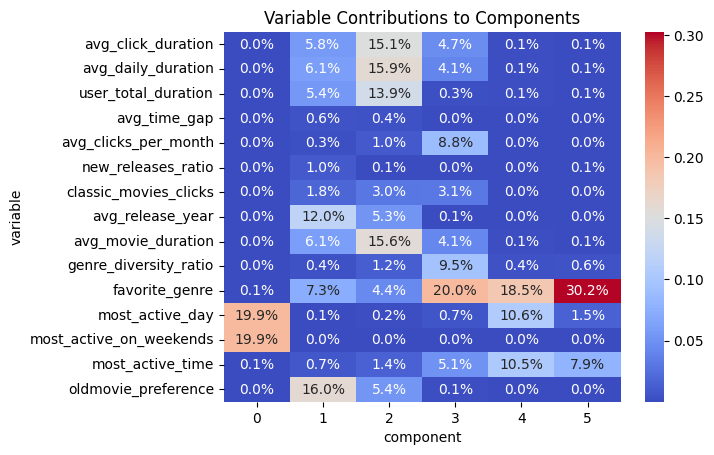

In [148]:
# Variable contributions to components using a heatmap
sns.heatmap(famd.column_contributions_, annot=True, fmt=".1%", cmap="coolwarm")
plt.title('Variable Contributions to Components')
plt.show()

Interpretation
- Component 0 seems to be associated with the user's activity patterns, particularly their most active days and whether they are more active on weekends. Users with higher values in this component might exhibit specific preferences regarding when they are most engaged with the platform.
- Component 1 appears to capture aspects related to the preferences for old movies and the average release year of movies clicked by the user. Users with higher values in this component might show preferences for movies released in certain years depending on whether they prefer old or actual movies.
- Users in component 2 are influenced by their average click duration, average daily duration, and total duration. This could represent a group of users who spend a significant amount of time on the platform daily, with a focus on the average duration of each click.
- Component 3 represents a segment of users who have a clear favorite genre but also enjoy exploring content from different genres. They are active participants on the platform, clicking on content frequently, and their viewing choices are influenced by both their favorite genre and a inclination to exploring content from various genres.
- Users in component 4 are users who have a clear preference for a particular genre and that also exhibit a consistent pattern of increased activity on particular days and specific time of day, which suggest a scheduled viewing routine.
- Similarly to the previous component, component 5 represents a segment of users whose behavior is notably characterized by his favorite genre and which have a preferred time of day when they are most active on the platform.

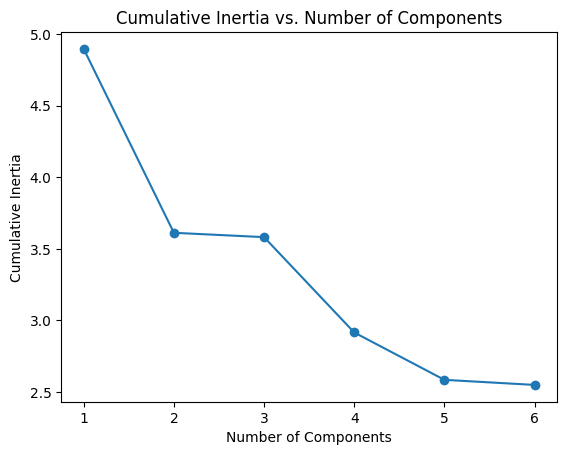

In [149]:
famd_fit=famd.fit(df_famd)
cumulative_inertia = famd_fit.percentage_of_variance_

# Plotting the cumulative inertia
plt.plot(range(1, 7), cumulative_inertia, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Inertia')
plt.title('Cumulative Inertia vs. Number of Components')
plt.show()

As the cumulative inertia hardly decreases from 5 components to 6 components, we decided to apply the FAMD dimensionality reduction method for the first 5 components.

In [150]:
# Accessing the transformed data with five components
reduced_df = df_famd_result.iloc[:, :5]
reduced_df.head()

component,0,1,2,3,4
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601
30,-1.658830,1.915326,0.054903,-2.703655,0.795014


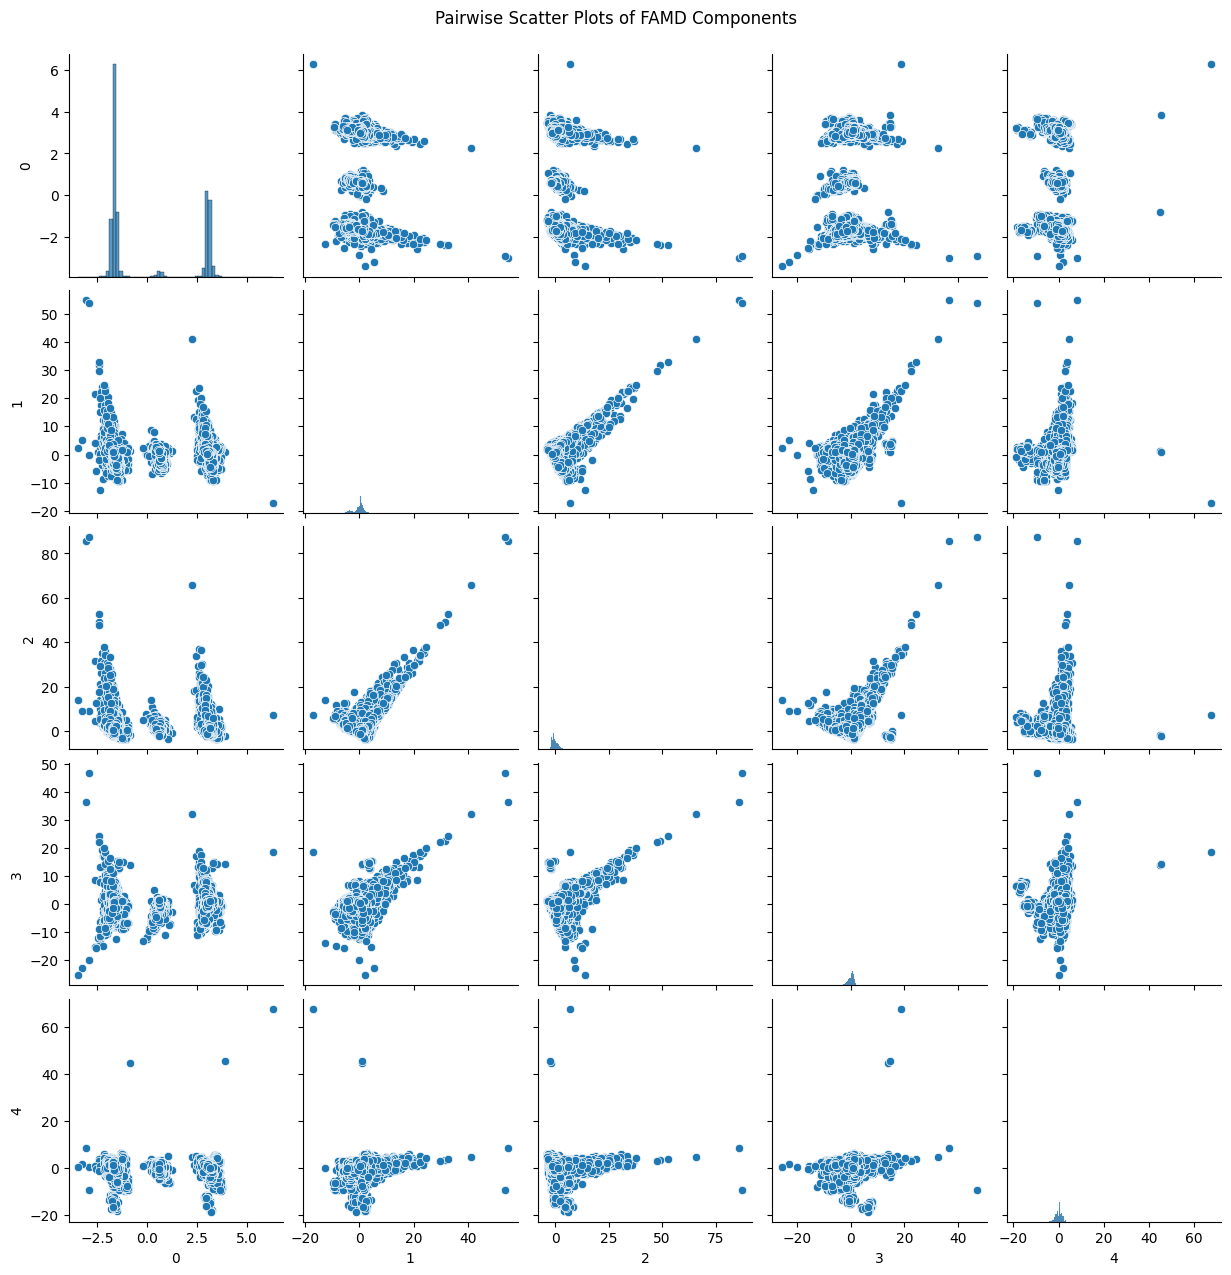

In [151]:
# Plotting pairwise scatter plots
sns.pairplot(reduced_df)
plt.suptitle('Pairwise Scatter Plots of FAMD Components', y=1.02)
plt.show()

### 2.3 Clustering!

1- Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

In [152]:
def map_reduce_kmeans(data, centroids):
    # Map step: Assign each data point to the nearest centroid
    distances = np.linalg.norm(data[:, None] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Reduce step: Calculate the mean to obtain new centroids
    new_centroids = np.array([data[labels == c].mean(axis=0) for c in range(len(centroids))])

    return labels, new_centroids

def custom_kmeans(data, n_clusters, max_iterations):
    # Initialization: Randomly select initial cluster representatives
    representatives = data[np.random.choice(data.shape[0], n_clusters, replace=False)]

    # Execute a fixed number of iterations or until convergence
    for iteration in range(max_iterations):
        # Map-Reduce step
        labels, new_representatives = map_reduce_kmeans(data, representatives)

        # Check for convergence
        if np.allclose(new_representatives, representatives, rtol=0.1):
            print("Convergence found!")
            break

        # Update representatives
        representatives = new_representatives

    return labels, representatives

# Example:
n_clusters_example = 3
max_iterations_example = 10

# Call the K-means function
data = reduced_df.values
labels_result, representatives_result = custom_kmeans(data, n_clusters_example, max_iterations_example)

print("Labels:", labels_result)
print("Representatives:", representatives_result)

Convergence found!
Labels: [0 2 2 ... 2 1 0]
Representatives: [[-0.19726153 -3.28143199  1.90304598  0.2094504  -0.1389456 ]
 [ 3.02279052  0.59037097 -0.29704598 -0.05383652  0.0512388 ]
 [-1.5900446   0.62716276 -0.38842218 -0.03122915  0.01225766]]


2- Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

Convergence found!
Convergence found!


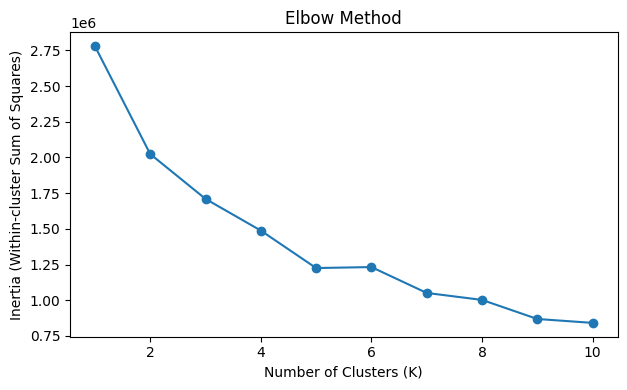

In [153]:
def elbow_method(data, max_clusters=10):
    inertia_values = []

    for k in range(1, max_clusters + 1):
        labels, centroids = custom_kmeans(data, k, max_iterations=10)
        inertia_values.append(np.sum((data - centroids[labels]) ** 2))

    # Plot Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-cluster Sum of Squares)')
    plt.title('Elbow Method')

    plt.tight_layout()
    plt.show()

    return inertia_values

inertia_values = elbow_method(reduced_df.values, max_clusters=10)

In [154]:
print('Inertia values:', inertia_values)

Inertia values: [2779160.4776577023, 2023940.9062849474, 1709869.3936025791, 1488050.3030860252, 1225705.2851536365, 1232530.6409472288, 1051334.941834863, 1002582.2466278016, 869034.9817017587, 841715.4200094858]


In [155]:
from sklearn.metrics import silhouette_score

def silhouette_score_method(data, max_clusters=10):
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        labels, _ = custom_kmeans(data, k, max_iterations=10)
        silhouette_scores.append(silhouette_score(data, labels))

    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method')

    plt.tight_layout()
    plt.show()

    return silhouette_scores

sil_scores = silhouette_score_method(reduced_df.values, max_clusters=10)

Convergence found!


KeyboardInterrupt: ignored

In [ ]:
print('Silhouette scores:', sil_scores)

Elbow Method: The inertia decreases continuously, and there's no clear "elbow." This might suggest that the data doesn't have a distinct, well-separated structure, making it challenging to find a clear elbow.

Silhouette Score Method: The maximum score occurs at K=6 (0.39). This suggests that, based on Silhouette Score alone, K=6 might be a good choice.

Considering both methods, K=6 might be a reasonable choice, as it has has a relatively high Silhouette Score although the Elbow Method doesn't show a distinct elbow.

3- Run the algorithm on the data obtained from the dimensionality reduction.

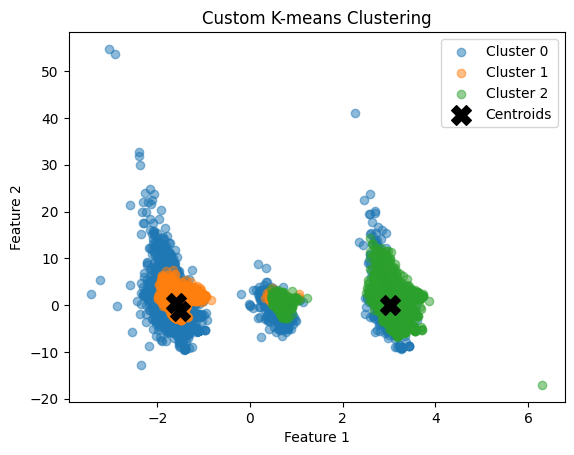

In [156]:
def plot_clusters(data, labels, centroids):
    # Scatter plot for each cluster
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.5)

    # Scatter plot for centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')

    plt.title('Custom K-means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

labels, centroids = custom_kmeans(reduced_df.values, 3, max_iterations=10)
plot_clusters(reduced_df.values, labels, centroids)

In [164]:
import numpy as np

def mapper(data_point, centroids):
    distances = np.linalg.norm(data_point - centroids, axis=1)
    label = np.argmin(distances)
    return label

def reducer(item):
    key, values = item
    new_centroid = np.sum([x[0] for x in values], axis=0) / np.sum([x[1] for x in values], axis=0)
    return (key, new_centroid)

def map_reduce_kmeans(data, centroids):
    labels = [mapper(point, centroids) for point in data]
    mapped = [(label, (point, 1)) for label, point in zip(labels, data)]

    grouped = {}
    for key, value in mapped:
        if key not in grouped:
            grouped[key] = []
        grouped[key].append(value)

    reduced = list(map(reducer, grouped.items()))
    return reduced, labels

def custom_kmeans(data, n_clusters, max_iterations):
    representatives = data[np.random.choice(data.shape[0], n_clusters, replace=False)]

    for _ in range(max_iterations):
        results, labels = map_reduce_kmeans(data, representatives)
        new_representatives = np.array([centroid for _, centroid in results])

        if np.allclose(new_representatives, representatives, rtol=0.1):
            print("Convergence found!")
            break

        representatives = new_representatives

    centroids = [centroid for _, centroid in results]

    return labels, np.vstack(centroids)

# Example:
n_clusters_example = 3
max_iterations_example = 10

data = reduced_df.values
labels_result, representatives_result = custom_kmeans(data, n_clusters_example, max_iterations_example)

print("Labels for each data point:", labels_result)
print("Centroids:")
for centroid in representatives_result:
    print(centroid)


Labels for each data point: [0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 1, 0, 2, 0, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,

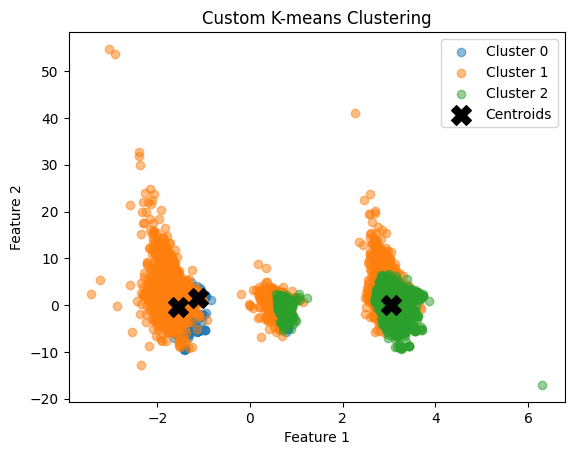

In [165]:
def plot_clusters(data, labels, centroids):
    # Scatter plot for each cluster
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.5)

    # Scatter plot for centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')

    plt.title('Custom K-means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_clusters(reduced_df.values, labels_result, representatives_result)

Convergence found!
Convergence found!


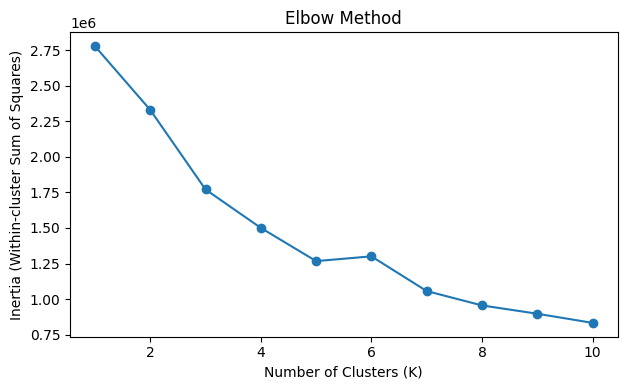

In [163]:
def elbow_method(data, max_clusters=10):
    inertia_values = []

    for k in range(1, max_clusters + 1):
        labels, centroids = custom_kmeans(data, k, max_iterations=10)
        inertia_values.append(np.sum((data - centroids[labels]) ** 2))

    # Plot Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-cluster Sum of Squares)')
    plt.title('Elbow Method')

    plt.tight_layout()
    plt.show()

    return inertia_values

inertia_values = elbow_method(reduced_df.values, max_clusters=10)

In [173]:
import numpy as np

def mapper(data_point, centroids):
    distances = np.linalg.norm(data_point - centroids, axis=1)
    label = np.argmin(distances)
    return label

def reducer(item):
    key, values = item
    new_centroid = np.sum([x[0] for x in values], axis=0) / np.sum([x[1] for x in values], axis=0)
    return (key, new_centroid)

def map_reduce_kmeans(data, centroids):
    labels = [mapper(point, centroids) for point in data]
    mapped = [(label, (point, 1)) for label, point in zip(labels, data)]

    grouped = {}
    for key, value in mapped:
        if key not in grouped:
            grouped[key] = []
        grouped[key].append(value)

    reduced = list(map(reducer, grouped.items()))
    return reduced, labels


# K-means++ initialization
def initialize_kmeans_plusplus(data, n_clusters):
    centroids = [data[np.random.choice(data.shape[0])]]

    for _ in range(1, n_clusters):
        distances = np.array([min(np.linalg.norm(point - centroid) ** 2 for centroid in centroids) for point in data])
        probabilities = distances / np.sum(distances)
        next_centroid_index = np.random.choice(data.shape[0], p=probabilities)
        centroids.append(data[next_centroid_index])

    return np.array(centroids)

# Custom K-means function using K-means++ initialization
def custom_kmeans(data, n_clusters, max_iterations):
    representatives = initialize_kmeans_plusplus(data, n_clusters)

    for _ in range(max_iterations):
        results, labels = map_reduce_kmeans(data, representatives)
        new_representatives = np.array([centroid for _, centroid in results])

        if np.allclose(new_representatives, representatives, rtol=0.1):
            print("Convergence found!")
            break

        representatives = new_representatives

    centroids = np.vstack([centroid for _, centroid in results])

    return labels, centroids

# Example usage
n_clusters_example = 3
max_iterations_example = 10

data = reduced_df.values  # Assuming 'reduced_df' contains the data
labels_result, representatives_result = custom_kmeans(data, n_clusters_example, max_iterations_example)

print("Labels for each data point:", labels_result)
print("Centroids:")
for centroid in representatives_result:
    print(centroid)


Labels for each data point: [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

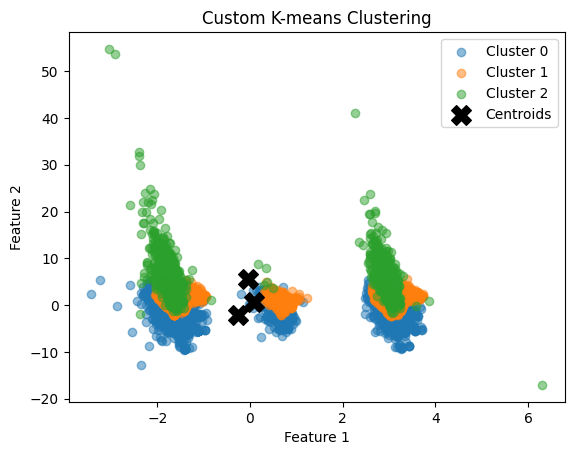

In [174]:
def plot_clusters(data, labels, centroids):
    # Scatter plot for each cluster
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.5)

    # Scatter plot for centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')

    plt.title('Custom K-means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_clusters(reduced_df.values, labels_result, representatives_result)

Convergence found!
Convergence found!
Convergence found!
Convergence found!
Convergence found!


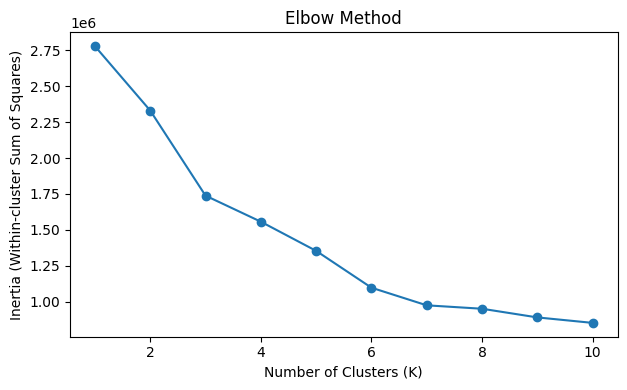

In [176]:
def elbow_method(data, max_clusters=10):
    inertia_values = []

    for k in range(1, max_clusters + 1):
        labels, centroids = custom_kmeans(data, k, max_iterations=10)
        inertia_values.append(np.sum((data - centroids[labels]) ** 2))

    # Plot Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-cluster Sum of Squares)')
    plt.title('Elbow Method')

    plt.tight_layout()
    plt.show()

    return inertia_values

inertia_values = elbow_method(reduced_df.values, max_clusters=10)

# 3. Bonus Question

To complete this question we are going to use HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) a density-based clustering algorithm that builds upon the principles of DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which identifies clusters based on the density of data points.

HDBSCAN extends DBSCAN by introducing a hierarchical approach to cluster identification, enabling it to handle clusters of varying densities and shapes more effectively.

In [ ]:
import hdbscan

# Assuming X contains your scaled feature data
clusterer = hdbscan.HDBSCAN(min_cluster_size=5000, min_samples=1000)
clusters = clusterer.fit_predict(reduced_df)

# Visualizing the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_df.iloc[:, 0], reduced_df.iloc[:, 1], c=clusters, cmap='viridis', s=50, edgecolors='k')
plt.title('HDBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Let's asses the quality of the fit using the Silhouette score.

In [ ]:
from sklearn import metrics

# Assuming X contains your scaled feature data
silhouette = metrics.silhouette_score(reduced_df, clusters)

print(f"Silhouette Score: {silhouette}")

The result is similar to what we get using K-means.

# 5. Algorithmic Question

### 5.a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

The first version of the code of the app is the following:

In [1]:
def max_score(initial_score, marks):
    def recurse(score, marks):
        if not marks:
            return score

        max_final_score = 0
        for i, mark in enumerate(marks):
            new_marks = marks[:i] + marks[i+1:]
            if mark < score:
                new_marks = [m + abs(mark - score) for m in new_marks]
            else:
                new_marks = [m - abs(mark - score) for m in new_marks]

            max_final_score = max(max_final_score, recurse(mark, new_marks))

        return max_final_score

    return recurse(initial_score, marks)

# Example usage
print(max_score(8, [5, 7, 1]))
print(max_score(25, [18, 24, 21, 32, 27]))
#print(max_score(30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]))

11
44


### 5.b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

Federico is right, this code is very slow. Indeed, the time Complexity can be analyzed as follows:

- Number of Recursive Calls: Each recursive call iterates over all remaining exams, making a recursive call for each exam.
- Exponential Growth: With n exams, there are n choices in the first call, n-1 in the second, and so on, leading to approximately $n!$ calls in total.

Therefore, the time complexity is $O(n!)$, which is extremely inefficient for even relatively small values of n.

For example, if $n=10$, the algorithm has to perform $10! = 3,628,800$ operations. If $n=20$, the algorithm has to perform $20! = 2,432,902,008,176,640,000$ operations.

### 5.c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

We update the code and create a recursive function that doesn't consider all permutations, but handles them in a "smart" way.

In [3]:
# Recursive function to find the highest score
def highest_score_recursive(S, marks):
    # Convert marks to numpy array
    marks = np.array(marks) # O(n)

    # Base case
    if len(marks) == 1: # O(1)
        return marks[0] # O(1)

    # Initialize the max score
    max_score = S # O(1)

    # Iterate through the marks
    for i in marks: # O(n)
        # Check if the mark is greater or smaller than the current score
        if i > S: # O(1)
            diff = i - S # O(1)
            # Update the marks
            marks1 = marks[marks != i] - diff # O(n)
            # Update the score
            S1 = i # O(1)
        else:
            diff = S - i # O(1)
            # Update the marks
            marks1 = marks[marks != i] + diff # O(n)
            # Update the score
            S1 = i # O(1)

        # Check if the length of the marks is even or odd
        if len(marks) % 2 == 0: # O(1)
            # Check if the marks are all smaller than the current score
            if all(marks1 < S1): #O(n)
                continue
            else:
                diff = max(marks1) - S1 # O(n)
                # Update the marks
                marks2 = marks1[marks1 != max(marks1)] - diff # O(n)
                # Update the score
                S2 = max(marks1) # O(n)
                # Find the highest score recursively
                max_score = max(max_score, highest_score_recursive(S2, marks2)) # * T(n-2)
        else:
            # Check if the marks are all greater than the current score
            if all(marks1 > S1): # O(n)
                continue
            else:
                diff = S1 - min(marks1) # O(n)
                # Update the marks
                marks2 = marks1[marks1 != min(marks1)] + diff # O(n)
                # Update the score
                S2 = min(marks1) # O(n)
                # Find the highest score recursively
                max_score = max(max_score, highest_score_recursive(S2, marks2)) # * T(n-2)

    return max_score

# Example usage with different S and marks lists
S1 = 8
marks1 = [1, 5, 7]
result1 = highest_score_recursive(S1, marks1)
print("The highest possible score for list 1 is:", result1)

S2 = 25
marks2 = [18, 24, 21, 32, 27]
result2 = highest_score_recursive(S2, marks2)
print("The highest possible score for list 2 is:", result2)

S3 = 30
marks3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_score_recursive(S3, marks3)
print("The highest possible score for list 3 is:", result3)

The highest possible score for list 1 is: 11
The highest possible score for list 2 is: 44
The highest possible score for list 3 is: 205


In [4]:
%timeit highest_score_recursive(S3, marks3)

1.19 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This code is already way faster than the first one. Let's compute the time complexity.

We denote the length of the `marks` list by $n$.
- **Base case** (when $n=1$): in this case, the function returns `marks[0]`. This is a constant operation, so it is $O(1)$.
- **General case**: the function iterates through the `marks` list and performs certain operations for each element and then it calls itself recusrively for each element. In the worst case, for each element in the list, the function will create a new list of `marks` of length $n-2$ and call itself, generating a *recursive tree*. For both even and odd lists of `marks`, the height of the tree will be $\frac{n}{2}$. The number of nodes in the tree will be $n * (n-2) * (n-4) * ... * 1 = n!!$. Thus the number of recursive calls will be $n!!$.
    - **Operations within each recursive call**: operations like array manipulations and finding minimum or maximum values within the list take $O(n)$ time in the worst case because they might need to traverse the entire list once.

The overall time complexity would be $O$(operations within each call × number of recursive calls).
Thus the overall time complexity of the algorithm is $O(n!!)$ as this is the term that dominates. Indeed,
$$
T(n) = T(n-2) * O(n) + O(n) \implies T(n) = T(n-4) * O(n-2) * O(n^2) + O(n)
\\
\implies T(n) = T(n-6) * O(n-4) * O(n-2) * O(n) \implies ... \implies T(n) = T(1) * O(3) * O(5) * ... * O(n-2) * O(n) \implies T(n) = O(n!!)
$$


This is already a good improvement from before, indeed, if $n=10$, the algorithm has to perform $10!! = 3840$ operations, which is much less than $10! = 3,628,800$ operations. If $n=20$, the algorithm has to perform $20!! = 3715891200$ operations, which is much less than $20! = 2,432,902,008,176,640,000$ operations. However, this is still a very slow algorithm and we now we can do better, so before Federico gets even more angry, let's try to improve it even more.

One way to do so, could be using dynamic programming, in particular memoization. We can store the results of the recursive calls in a dictionary and use them to avoid recomputing the same results multiple times. This way, we can reduce the time complexity.

In [5]:
# Recursive function to find the highest score with memoization
def highest_score_recursive(S, marks, memo={}):

    # Convert marks to tuple to use as dictionary key
    marks = tuple(sorted(marks))

    # Check if result is already in memo
    if (S, marks) in memo:
        return memo[(S, marks)]

    # Base case
    if len(marks) == 1:
        return marks[0]

    # Initialize the max score
    max_score = S

    # Iterate through the marks
    for i in marks:
        # Check if the mark is greater or smaller than the current score
        if i > S:
            diff = i - S
            # Update the marks
            marks1 = [m for m in marks if m != i]
            marks1 = [m - diff for m in marks1]
            # Update the score
            S1 = i
        else:
            diff = S - i
            # Update the marks
            marks1 = [m for m in marks if m != i]
            marks1 = [m + diff for m in marks1]
            # Update the score
            S1 = i

        # Check if the length of the marks is even or odd
        if len(marks) % 2 == 0:
            # Check if the marks are all smaller than the current score
            if all(m < S1 for m in marks1):
                continue
            else:
                diff = max(marks1) - S1
                # Update the marks
                marks2 = [m for m in marks1 if m != max(marks1)]
                marks2 = [m - diff for m in marks2]
                # Update the score
                S2 = max(marks1)
                # Find the highest score recursively
                max_score = max(max_score, highest_score_recursive(S2, marks2, memo))
        else:
            # Check if the marks are all greater than the current score
            if all(m > S1 for m in marks1):
                continue
            else:
                diff = S1 - min(marks1)
                # Update the marks
                marks2 = [m for m in marks1 if m != min(marks1)]
                marks2 = [m + diff for m in marks2]
                # Update the score
                S2 = min(marks1)
                # Find the highest score recursively
                max_score = max(max_score, highest_score_recursive(S2, marks2, memo))

    # Store result in memo before returning
    memo[(S, marks)] = max_score
    return max_score


# Example usage with different S and marks lists
S1 = 8
marks1 = [1, 5, 7]
result1 = highest_score_recursive(S1, marks1)
print("The highest possible score for list 1 is:", result1)


S2 = 25
marks2 = [18, 24, 21, 32, 27]
result2 = highest_score_recursive(S2, marks2)
print("The highest possible score for list 2 is:", result2)

S3 = 30
marks3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_score_recursive(S3, marks3)
print("The highest possible score for list 3 is:", result3)

The highest possible score for list 1 is: 11
The highest possible score for list 2 is: 44
The highest possible score for list 3 is: 205


In [6]:
%timeit highest_score_recursive(S3, marks3)

1.33 µs ± 371 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


This code is noticeably faster than the previous one. However, if the `marks` list is very long, the recursive tree will still be very deep and the algorithm will still be slow. Indeed, in the worst case, if not enough results are stored in the dictionary, the algorithm will still have to perform $n!!$ operations.
We need an approach that doesn't require a recursive tree if we want to handle very long lists of `marks`.

In [7]:
def highest_score_opt(S, marks):

    pd = len(marks) # O(1)
    marks = np.array(marks) # O(n)

    index = 0 # O(1)
    while len(marks): # O(n)
        index += 1 # O(1)
        if (index % 2 == 0 and pd % 2 == 0) or (index % 2 != 0 and pd % 2 != 0): # O(1)
            p = max(marks) # O(n)
        else:
            p = min(marks) # O(n)

        if p > S: # O(1)
            marks = marks[marks != p] - (p - S) # O(n)
            S = p # O(1)
        else:
            marks = marks[marks != p] + (S - p) # O(n)
            S = p # O(1)
    return S

S1 = 8
marks1 = [1, 5, 7]
result1 = highest_score_opt(S1, marks1)
print("The highest possible score for list 1 is:", result1)


S2 = 25
marks2 = [18, 24, 21, 32, 27]
result2 = highest_score_opt(S2, marks2)
print("The highest possible score for list 2 is:", result2)

S3 = 30
marks3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_score_opt(S3, marks3)
print("The highest possible score for list 3 is:", result3)

The highest possible score for list 1 is: 11
The highest possible score for list 2 is: 44
The highest possible score for list 3 is: 205


In [9]:
%timeit highest_score_opt(S3, marks3)

127 µs ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The while loop is the most significant part of the code in terms of time complexity. It runs n times, where n is the length of the input list `marks`. Inside the loop, there are operations that also run in $O(n)$ time, such as `max(marks)`, `min(marks)`, and the array slicing and subtraction operations.

Since these $O(n)$ operations are inside the loop that runs n times the overall time complexity is $O(n^2)$ for the while loop.

All other operations outside the loop run in constant time, $O(1)$.

So, the overall time complexity of the function is dominated by the while loop, which is $O(n^2)$.

### 5.d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

In [10]:
import heapq

def highest_score_opt(S, marks):
    heap = []
    heapq.heapify(heap)  # Create an empty heap

    for mark in marks:
        heapq.heappush(heap, -mark)  # Push the negative values onto the heap for max heap

    index = 0

    while heap:
        index += 1
        p = -heapq.heappop(heap)  # Pop the maximum element from the heap

        if (index % 2 == 0 and len(heap) % 2 == 0) or (index % 2 != 0 and len(heap) % 2 != 0):
            if p > S:
                return p
            else:
                S += p
        else:
            if p > S:
                return p
            else:
                S += p

    return S

S1 = 8
marks1 = [1, 5, 7]
result1 = highest_score_opt(S1, marks1)
print("The highest possible score for list 1 is:", result1)

S2 = 25
marks2 = [18, 24, 21, 32, 27]
result2 = highest_score_opt(S2, marks2)
print("The highest possible score for list 2 is:", result2)

S3 = 30
marks3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_score_opt(S3, marks3)
print("The highest possible score for list 3 is:", result3)


The highest possible score for list 1 is: 21
The highest possible score for list 2 is: 32
The highest possible score for list 3 is: 79


This is the best result that Chat GPT could proide. It claims that the time complexity is $O(n \cdot \log n)$. However, the code is not correct as it doesn't correctly find the highest possible score.